## DCGANs on street view images

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torchvision import datasets, transforms
transform = transforms.ToTensor()

sv_train = datasets.SVHN('data', download=True, split='train', transform=transform)
sv_loader = torch.utils.data.DataLoader(sv_train, shuffle=True, batch_size=128)

Using downloaded and verified file: data/train_32x32.mat


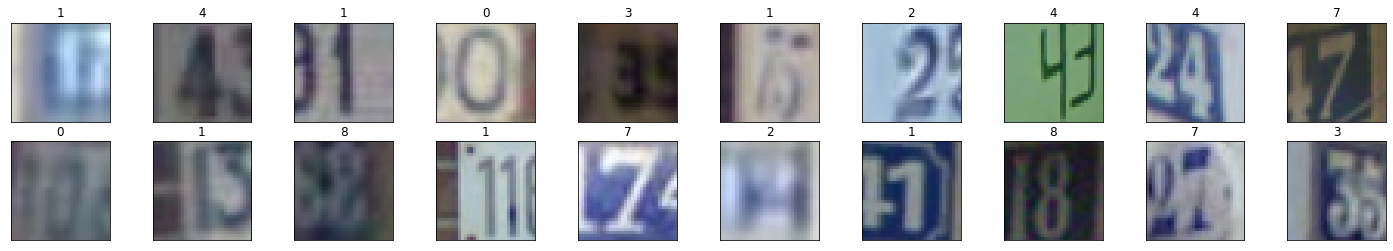

In [3]:
## visualize some images
images, labels = iter(sv_loader).next()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(labels[idx].item())

## Preprocessing, scaling to -1, 1

In [4]:
img = images[0]

print(f'Min: {img.min()} | max: {img.max()}')

Min: 0.33725491166114807 | max: 1.0


In [5]:
def scale(x, feature_range=(-1,1)):
    min, max = feature_range
    x = x*(max - min) + min
    return x

In [6]:
scaled_img = scale(img)
print(f'Min: {scaled_img.min()} | max: {scaled_img.max()}')

Min: -0.32549017667770386 | max: 1.0


---
## Define the Model

## Discriminator


In [7]:
import torch.nn as nn
import torch.nn.functional as F
# helper conv 
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers=[]
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim = 32):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
    #32
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
    #16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
    #8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
    # 4
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
    
    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)        
        return x
D = Discriminator(32)
D

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

## Generator

In [9]:
# helper conv 
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers=[]
    
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [10]:
class Generator(nn.Module):
    def __init__(self, z_size=100, conv_dim=32):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, self.conv_dim*4*4*4)

        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, kernel_size=4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, kernel_size=4)
        self.t_conv3 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False)
        
    def forward(self, x):
        x = self.fc(x)
        # batch_size, depth, 4 * 4
        x = x.view(-1, self.conv_dim*4, 4, 4)

        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = torch.tanh(self.t_conv3(x))

        return x

G = Generator()
G

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [11]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

## Defining losses

In [12]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    criterion = nn.BCEWithLogitsLoss()
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    labels.to(device)
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [13]:
import torch.optim as optim

d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=[0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=[0.5, 0.999])

## Training loop

In [14]:
%%time
epochs = 50
samples = []
losses = []
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
fixed_z = np.random.uniform(-1,1, size=(16,100)) # Size of latent vector to give to generator z_size = 100
fixed_z = torch.from_numpy(fixed_z).float()
## set to training mode
D.train()
G.train()
for epoch in range(epochs):
    for real_images, _ in sv_loader:
        batch_size = real_images.size(0) # or .shape[0]
        #rescale images from [0,1] to [-1,1]
        real_images = real_images*2 - 1
        real_images.to(device)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        # 1. Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=False)
        # 2. Train with fake images
        z = np.random.uniform(-1,1, size=(batch_size,100))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        fake_images.to(device)
        #fake loss
        D_fake = D(fake_images)
        d_f_loss = fake_loss(D_fake)
        # sum loss and backprop
        d_loss = d_real_loss + d_f_loss
        d_loss.backward()
        d_optimizer.step()
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        # Train with fake images and flipped labels
        z = np.random.uniform(-1,1, size=(batch_size,100))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        fake_images.to(device)
        # discriminator loss on fake images
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) #using real loss to flip the images
        g_loss.backward()
        g_optimizer.step()
        
    print(f'Epoch: {epoch+1} |\t D Loss: {d_loss.item():6f} |\t G Loss: {g_loss.item():6f}')
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss    
    losses.append((d_loss.item(), g_loss.item()))
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    fixed_z.to(device)
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch: 1 |	 D Loss: 0.428731 |	 G Loss: 2.045167
Epoch: 2 |	 D Loss: 1.120553 |	 G Loss: 4.209315
Epoch: 3 |	 D Loss: 0.506983 |	 G Loss: 3.951134
Epoch: 4 |	 D Loss: 0.850449 |	 G Loss: 4.015634
Epoch: 5 |	 D Loss: 0.685346 |	 G Loss: 0.614234
Epoch: 6 |	 D Loss: 0.118902 |	 G Loss: 3.314098
Epoch: 7 |	 D Loss: 0.175292 |	 G Loss: 4.093009
Epoch: 8 |	 D Loss: 0.203308 |	 G Loss: 2.525608
Epoch: 9 |	 D Loss: 0.115718 |	 G Loss: 4.120343
Epoch: 10 |	 D Loss: 0.305713 |	 G Loss: 2.943372
Epoch: 11 |	 D Loss: 0.311027 |	 G Loss: 2.947375
Epoch: 12 |	 D Loss: 0.070356 |	 G Loss: 4.384356
Epoch: 13 |	 D Loss: 0.505591 |	 G Loss: 0.709230
Epoch: 14 |	 D Loss: 0.205197 |	 G Loss: 3.528194
Epoch: 15 |	 D Loss: 0.184698 |	 G Loss: 2.763969
Epoch: 16 |	 D Loss: 0.893511 |	 G Loss: 2.206529
Epoch: 17 |	 D Loss: 0.211029 |	 G Loss: 3.376225
Epoch: 18 |	 D Loss: 0.304737 |	 G Loss: 3.716161
Epoch: 19 |	 D Loss: 0.155983 |	 G Loss: 2.750553
Epoch: 20 |	 D Loss: 0.160986 |	 G Loss: 4.152214
Epoch: 21

## Training Loss

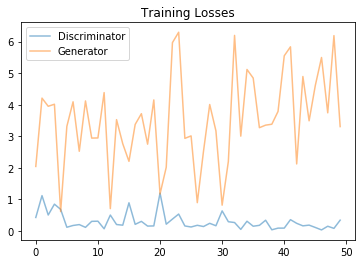

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [16]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

## View samples

In [17]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

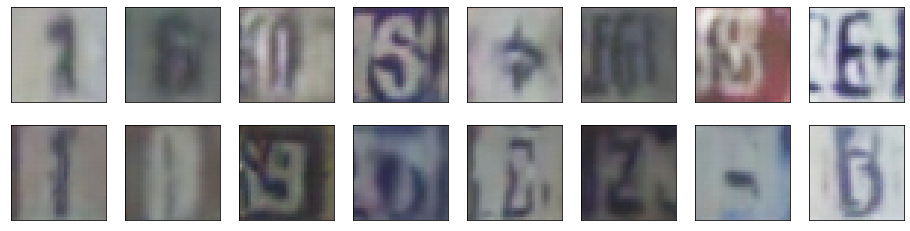

In [18]:
_ = view_samples(-1, samples)